In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import jupyter_helper
from keras.backend import clear_session
import pandas as pd
import numpy as np
from LSTM_for_Stock.data_processor import DataLoaderStock
from LSTM_for_Stock.data_processor import DataHelper
from LSTM_for_Stock.data_processor import Wrapper_default
from LSTM_for_Stock.data_processor import Normalize
from QUANTAXIS.QAFetch.QAQuery_Advance import QA_fetch_stock_block_adv as get_block
from QUANTAXIS.QAFetch.QAQuery import QA_fetch_stock_to_market_date
import xgboost as xgb
import datetime
import matplotlib.pyplot as plt
#设定绘图的默认大小
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC','SimHei']
matplotlib.rcParams['axes.unicode_minus']=False #用来正常显示负号

import matplotlib.pyplot as plt

#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set(font=['Noto Sans CJK SC','SimHei'])

Using TensorFlow backend.


In [17]:
window = 3
days = 1


def test_dt(code):
    """判断股票上市时间是否晚于指定时间"""
    end = datetime.datetime(2005, 1, 1)
    s=QA_fetch_stock_to_market_date(code)
    if s:
        return datetime.datetime.strptime(str(s), '%Y%m%d') <= end
    try:
        return datetime.datetime.strptime(str(
            QA.QAFetch.QATdx.QA_fetch_get_stock_info(code).iloc[0]['ipo_date']),
            '%Y%m%d') <= end
    except:
        return False


def test_code(code):
    return code[0] in ['0', '3', '6']


def get_block_code(code) -> (str):
    """按照证监会行业分类，获取指定股票的同分类所有股票代码"""
    df = get_block()
    code_block = df.get_code(code).data
    code_zjh_lbock_name = \
        code_block[code_block['type'] == 'zjhhy'].reset_index()[
            'blockname'].values[0]
    return [c for c in df.get_block(code_zjh_lbock_name).code if c != code]


def get_feature_importance_data(data_income):
    data = data_income.copy()
    data = Normalize().build(data)
    y = data['close']
    X = data.drop(columns=['close']).iloc[:, :]

    train_samples = int(X.shape[0] * 0.65)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]

    return (X_train, y_train), (X_test, y_test)


codes = [code for code in get_block_code(
    '000002') if test_dt(code) and test_code(code)]

dl = DataLoaderStock('000002', wrapper=Wrapper_default(), appends=codes)
df = dl.load()

In [18]:
codes

['600246',
 '000667',
 '600136',
 '000670',
 '600638',
 '000897',
 '000620',
 '600807',
 '600240',
 '000029',
 '000038',
 '000042',
 '000616',
 '000711',
 '000889',
 '600052',
 '600167',
 '600641',
 '600687',
 '600724',
 '600733',
 '600745',
 '600753',
 '600759',
 '600766',
 '600094',
 '000656',
 '600173',
 '000631',
 '000981',
 '000040',
 '600683',
 '000150',
 '600393',
 '000736',
 '600767',
 '000863',
 '600238',
 '000546',
 '000046',
 '600208',
 '000718',
 '000797',
 '600256',
 '600639',
 '000668',
 '600658',
 '600576',
 '000534',
 '600239',
 '600663',
 '600565',
 '600648',
 '600665',
 '600340',
 '600376',
 '600730',
 '600890',
 '000838',
 '600266',
 '000918',
 '000043',
 '000031',
 '600606',
 '000049',
 '000502',
 '600657',
 '600064',
 '600823',
 '002016',
 '600225',
 '600223',
 '600077',
 '000505',
 '600634',
 '000007',
 '600748',
 '000036',
 '000965',
 '600716',
 '600743',
 '600162',
 '600322',
 '000628',
 '600113',
 '600215',
 '000517',
 '600503',
 '000402',
 '000671',
 '600833',

In [19]:
df

,open,high,low,close,volume,amount,open_bench,high_bench,low_bench,close_bench,...,low_000506,close_000506,volume_000506,amount_000506,open_600568,high_600568,low_600568,close_600568,volume_600568,amount_600568
date,,,,,,,,,,,,,,,,,,,,,
2009-06-05,8.410506,8.541920,8.240441,8.263632,1.402332e+06,1.174445e+09,2966.06,2975.18,2937.18,2939.31,...,6.844440,7.083295,1.197699e+06,921279232.0,2.248688,2.367293,2.245483,2.367293,296236.873795,69429536.0
2009-06-08,8.240332,8.776225,8.240332,8.651960,2.480367e+06,2.127939e+09,2937.64,2978.23,2912.49,2948.48,...,6.844440,7.083295,1.197699e+06,921279232.0,2.372102,2.431404,2.299977,2.381718,313644.221686,74748176.0
2009-06-09,8.706326,8.947090,8.550995,8.822825,2.079951e+06,1.821360e+09,2948.95,2960.90,2892.72,2960.56,...,6.729131,6.745603,4.716921e+05,324252832.0,2.357677,2.396143,2.296771,2.344855,175976.432717,41118100.0
2009-06-10,8.853891,8.908257,8.667493,8.714093,1.475437e+06,1.291516e+09,2972.42,2995.70,2966.58,2989.59,...,6.407911,6.407911,3.615273e+05,234691936.0,2.317607,2.368896,2.293566,2.333635,155062.658476,36032624.0
2009-06-11,8.714093,8.721859,8.387897,8.457796,1.834288e+06,1.561810e+09,2982.97,3000.86,2951.27,2961.63,...,6.202002,6.465566,3.095130e+05,199004064.0,2.299977,2.394541,2.299977,2.324019,117471.521900,27258660.0
2009-06-12,8.387897,8.698560,8.294698,8.512162,1.569577e+06,1.332529e+09,2955.57,2976.86,2883.32,2906.29,...,6.144347,6.144347,1.986368e+05,123825696.0,2.309594,2.380116,2.208619,2.229455,198880.509458,45068132.0
2009-06-15,8.496629,8.659727,8.310231,8.628660,1.067241e+06,9.110765e+08,2911.42,2967.10,2898.07,2966.19,...,5.839601,5.897255,2.859372e+05,169929696.0,2.189386,2.288758,2.189386,2.282347,113628.179140,25507700.0
2009-06-16,8.589828,8.597594,8.349064,8.411196,1.363322e+06,1.151664e+09,2936.51,2979.41,2929.04,2961.22,...,5.847837,5.913728,1.410582e+05,83768080.0,2.253497,2.356074,2.253497,2.336841,150464.373387,34894112.0
2009-06-17,8.395663,9.249986,8.224799,9.226686,4.551812e+06,4.039004e+09,2957.58,3017.41,2930.49,3010.59,...,5.790182,5.963146,1.483660e+05,87584392.0,2.336841,2.452240,2.296771,2.436213,232746.847937,55789816.0


In [20]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)

In [21]:
regressor = xgb.XGBRegressor(
    gamma=0.0,
    n_estimators=1000,
    base_score=0.7,
    colsample_bytree=1,
    learning_rate=0.005)
xgbModel = regressor.fit(
    X_train_FI,
    y_train_FI,
    eval_set=[(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
    verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

C:\Users\GuQiang\AppData\Local\conda\conda\envs\finance35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\GuQiang\AppData\Local\conda\conda\envs\finance35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Text(0.5, 1.0, '特征技术指标的重要性')

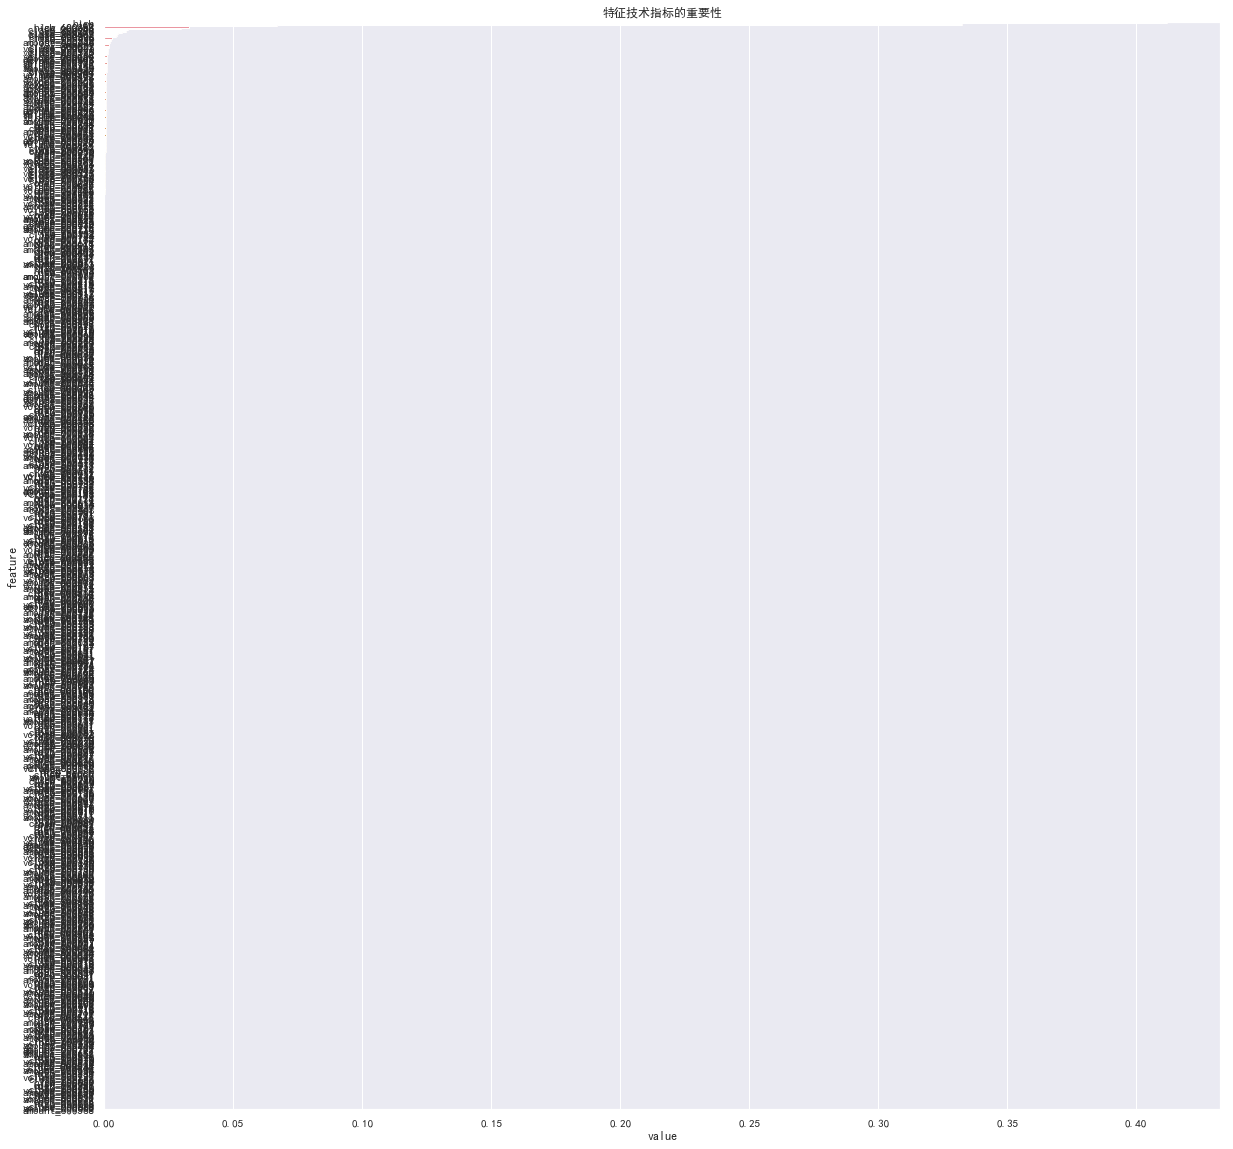

In [22]:
plt.figure(figsize=(20,20))
df=pd.DataFrame({'feature':X_test_FI.columns,'value':xgbModel.feature_importances_.tolist()})
df=df.sort_values("value", ascending=False)
g=sns.barplot(data=df,x='value',y='feature')
g.axes.set_title('特征技术指标的重要性')

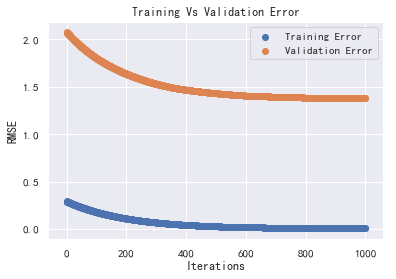

In [23]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [24]:
df

,feature,value
1,high,0.411961
2,low,0.332351
252,high_600208,0.066986
313,low_600663,0.032834
248,close_000046,0.029728
355,low_600890,0.009118
662,close_600383,0.008301
542,close_000402,0.006808
314,close_600663,0.005402
254,close_600208,0.004795
